In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import quandl
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

from future import GenericFuture
from curve import CommodityCurve

In [22]:
filename = "../data/MultipleTestData.xlsx"
ir_file = "../data/InterestRates.xlsx"
data_dir = "../data/"

start_date = "2000-01-01"

raw_ust = quandl.get("USTREASURY/YIELD", start_date=start_date)
raw_ust.head()
co_tickers = {"Brent": "ICE_B", "WTI": "CME_CL", "Wheat": "CME_W",
              "Corn": "CME_C", "Copper": "CME_HG", "Lead": "MCX_PB",
              "Aluminium": "CME_ALI", "Gas": "CME_NG", "Hogs": "CME_LN",
              "Coffee": "ICE_KC", "Cotton": "ICE_CT", "Cocoa": "ICE_CC",
              "Sugar": "ICE_SB", "HeatOil": "CME_HO", "Gasoline": "CME_RB",
              "Lumber": "CME_LB", "NaturalGas": "CME_NG", "Gold": "CME_GC",
              "Platinum": "CME_PL", "AUD": "CME_AD", "ZAR": "CME_RA", "NOK": "CME_NJ",
              "CAD": "CME_CD", "UST5": "CME_FV", "UST2": "CME_TU", "UST10": "CME_TY",
              "FedFunds": "CME_FF"}


In [20]:
data = pd.read_excel(filename, index_col="Date")
commodities = ["Corn", "Brent", "Lumber", "Copper"]
tickers = [co_tickers[c] + "[1-3]$" for c in commodities]
data = data["2000-01-01":]
data.head()

,CME_AD1,CME_AD2,CME_ALI1,CME_ALI2,CME_C1,CME_C2,CME_C3,CME_CD1,CME_CD2,CME_CD3,...,ICE_CT2,ICE_CT3,ICE_KC1,ICE_KC2,ICE_KC3,ICE_SB1,ICE_SB2,ICE_SB3,MCX_PB1,MCX_PB2
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.6621,0.6626,NaN,NaN,200.75,208.00,214.75,0.6931,0.6946,0.6958,...,52.36,53.71,116.50,119.50,122.00,6.10,6.24,6.34,NaN,NaN
2000-01-04,0.6561,0.6566,NaN,NaN,203.00,209.75,216.50,0.6899,0.6914,0.6926,...,52.12,53.48,116.25,119.15,121.65,5.77,5.99,6.13,NaN,NaN
2000-01-05,0.6584,0.6589,NaN,NaN,203.00,210.00,217.00,0.6916,0.6931,0.6943,...,52.83,54.10,118.60,121.35,123.65,5.81,6.02,6.18,NaN,NaN
2000-01-06,0.6557,0.6562,NaN,NaN,203.75,210.75,217.75,0.6864,0.6879,0.6891,...,53.36,54.70,116.85,119.55,121.85,5.77,6.00,6.18,NaN,NaN
2000-01-07,0.6561,0.6566,NaN,NaN,207.00,214.00,220.75,0.6879,0.6894,0.6906,...,55.09,56.37,114.15,116.85,119.30,5.84,6.06,6.23,NaN,NaN


In [24]:
expiries = pd.read_excel(data_dir + "CornContractExpiries.xlsx")
root_ticker = co_tickers["Corn"]
generic_futures = [1, 2]
tickers = [root_ticker + str(i) for i in generic_futures]
near_future_data = data.loc[:, tickers[0]]
far_future_data = data.loc[:, tickers[1]]
near_future_ticker = tickers[0]
far_future_ticker = tickers[1]
near_future = generic_futures[0]
far_future = generic_futures[1]

near_future_expiries = expiries[["Date", str(near_future) + "C_Expiry"]].set_index("Date")
far_future_expiries = expiries[["Date", str(far_future) + "C_Expiry"]].set_index("Date")

near_future = GenericFuture(ticker=near_future_ticker, number=near_future, data=near_future_data)
far_future = GenericFuture(ticker=far_future_ticker, number=far_future, data=far_future_data)

near_future.clean_data()
far_future.clean_data()

near_future.set_expiries(near_future_expiries)
far_future.set_expiries(far_future_expiries)
basis = near_future.calculate_basis(far_future)
log_basis = near_future.calculate_basis(far_future, log=True)
basis.head()

Date
2000-01-03   -0.215633
2000-01-04   -0.199087
2000-01-05   -0.206215
2000-01-06   -0.205481
2000-01-07   -0.202360
dtype: float64

<AxesSubplot:xlabel='Date'>

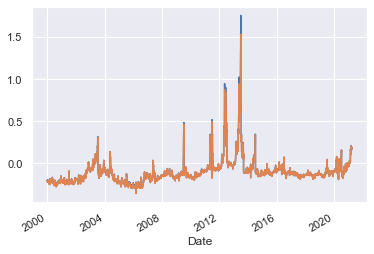

In [25]:
basis.plot()
log_basis.plot()

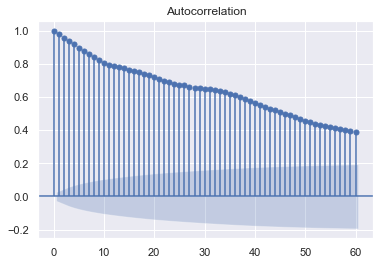

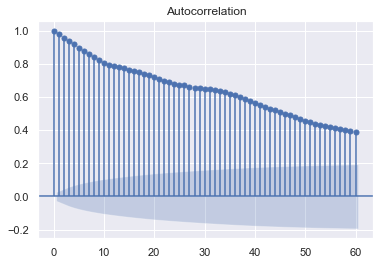

In [26]:
plot_acf(basis.dropna().values.squeeze(), lags=60)

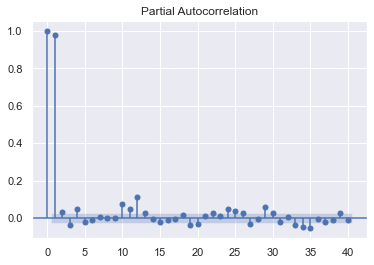

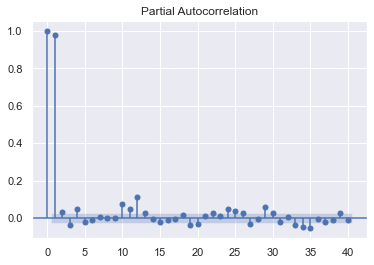

In [27]:
plot_pacf(basis.dropna().values.squeeze(), lags=40)

In [28]:
monthly_basis = basis.resample('M', convention='end').last()

<AxesSubplot:xlabel='Date'>

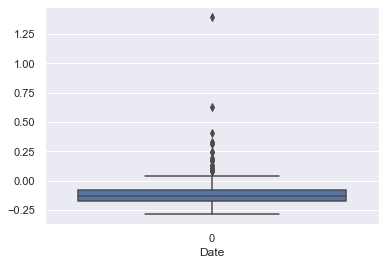

In [42]:
monthly_basis.plot()
sns.boxplot(data=monthly_basis)

<AxesSubplot:>

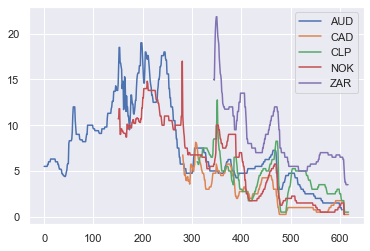

In [30]:
interest_rates = pd.read_excel(ir_file)
interest_rates.plot()

In [31]:
ust = raw_ust
ust = ust / 100
ust_st = ust["3 MO"]
ust_st_m = ust_st.resample('M', convention="end").last()
ust_mt = ust["5 YR"]
ust_mt_m = ust_mt.resample('M', convention="end").last()
ust_lt = ust["10 YR"]
ust_lt_m = ust_lt.resample('M', convention="end").last()


In [32]:
ust_st.resample('M', convention="end").last()

Date
2000-01-31    0.0576
2000-02-29    0.0578
2000-03-31    0.0588
2000-04-30    0.0582
2000-05-31    0.0563
               ...  
2020-12-31    0.0009
2021-01-31    0.0006
2021-02-28    0.0004
2021-03-31    0.0003
2021-04-30    0.0002
Freq: M, Name: 3 MO, Length: 256, dtype: float64

ADF Statistic: -5.057116
p-value: 0.000017
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


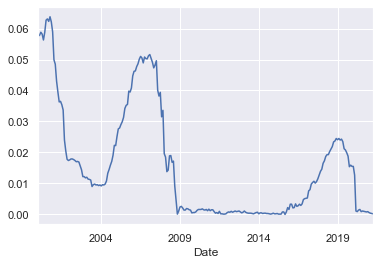

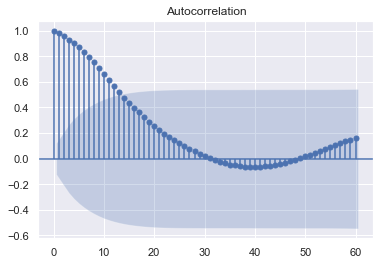

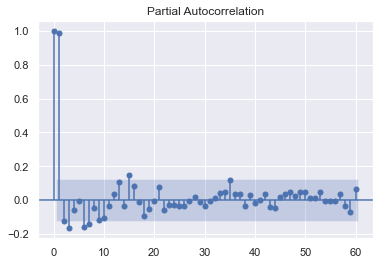

In [41]:
ust_st_m.plot()
delta = ust_st_m - ust_st_m.shift(1)
plot_acf(ust_st_m.values.squeeze(), lags=60)
plot_pacf(ust_st_m.values.squeeze(), lags=60)
result = adfuller(basis.dropna().values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

In [119]:
ust_st_m = ust_st_m.loc[monthly_basis.index]
ust_mt_m = ust_mt_m.loc[monthly_basis.index]
X = sm.add_constant(ust_st_m)
est = sm.OLS(monthly_corn_basis.values.squeeze(), X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     63.52
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           5.46e-14
Time:                        21:01:33   Log-Likelihood:                 154.79
No. Observations:                 255   AIC:                            -305.6
Df Residuals:                     253   BIC:                            -298.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0484      0.011     -4.384      0.0